# Genetsko programiranje

Genetsko programiranje je nastalo sa ciljem evoluiranja programa.
Jedinka je u ovom slučaju program, a najprirodnija reprezentacija je apstraktno sintaksno stablo.
Potrebno je osmisliti adekvatne operatore ukrštanja i mutacije, a ostalo je otprilike isto kao i kod običnog genetskog algoritma.
Jedan od načina kako se mogu realizovati ukrštanje i mutacija nad stablima:
- ukrštanje - zamena dva podstabla iz dva roditelja,
- mutacija - zamena slučajno odabrang podstabla novogenerisanim podstablom.

Ne očekujemo preveliki uspeh genetskog programiranja uopšteno u programiranju, ali postoje domeni u kojima može da bude uspešno (uspešnije od ljudi).
Oblast primene ne moraju da budu programi, već bilo šta što možemo da predstavimo u obliku stabla.

U primeru ispod rešavamo problem donekle sličan igri Moj broj iz Slagalice.
Dat nam je ciljni broj i treba da dođemo do njega uz korišćenje osnovnih aritmetičkih operacija i brojeva iz opsega od -10 do 10.
Dodatno ograničenje je da naše rešenje treba da bude izraz oblika $(a \star b) \circ (c \diamond d)$, gde su $a, b, c, d \in [-10, 10]$, a $\star, \circ, \diamond \in \{+,-,*,/\}$.

Za vežbu implementirati genetsko programiranje za igru Moj broj bez ovih dodatnih ograničenja.

Zbog ograničenja izraza na ovakve $(a \star b) \circ (c \diamond d)$, znamo da je naše stablo potpuno i lako možemo da iskoristimo listu da sačuvamo elemente stabla.
Koren je na poziciji $0$, a potomoci čvora na indeksu $i$ su na indeksima $2*i+1$ i $2*i+2$.

Iskoristićemo ugrađenu funkciju $eval$ koja za datu stringovsku reprezentaciju izraza izračunava njegovu vrednost.

In [1]:
eval("3+7")

10

In [80]:
import random


class Individual:
    """
    Individual of genetic programming
    code - represents one solution
    fitness - quality of the solution
    """
    def __init__(self, goal: int):
        self.code = [self.random_operation() for _ in range(3)]
        self.code += [self.random_operand() for _ in range(4)]
        self.goal = goal
        self.calc_fitness()

    def random_operation(self):
        # deljenje smo izbacili da ne bismo morali da brinemo o deljivosti brojeva i deljenju nulom, ali nije suštinski teško dodati ga
        return random.choice(['+', '-', '*']) #, '//'])
    
    def random_operand(self):
        return random.randint(-10, 10)

    def eval_tree(self, idx: int):
        if isinstance(self.code[idx], int):
            return self.code[idx]
        try:
            return eval(f'( {self.eval_tree(2 * idx + 1)} ) {self.code[idx]} ( {self.eval_tree(2 * idx + 2)} )')
        except:
            return float('inf')

    def calc_fitness(self):
        # fitnes je apsolutna vrednost razlike između vrednosti izraza i ciljne vrednosti
        value = self.eval_tree(idx=0)
        self.fitness = abs(value - self.goal)

    def __lt__(self, other: "Individual"):
        # overload-ujemo operator < da bismo mogli da koristimo funkcije kao sto je sort bez parametra key
        return self.fitness < other.fitness

In [81]:
i = Individual(goal=123)
i.code

['+', '-', '-', 6, -4, 3, 4]

In [82]:
i.fitness

114

In [83]:
i < i

False

In [84]:
def selection(population, k):
    return max(random.sample(population, k))

In [85]:
def swap_subtrees(child1: Individual, child2: Individual, idx: int):
    child1.code[idx], child2.code[idx] = child2.code[idx], child1.code[idx]
    if isinstance(child1.code[idx], int):
        return
    swap_subtrees(child1, child2, idx=2 * idx + 1)
    swap_subtrees(child1, child2, idx=2 * idx + 2)

In [86]:
from copy import deepcopy


def crossover(parent1: Individual, parent2: Individual, child1: Individual, child2: Individual):
    """
    Crossover two parents to produce two children - swap random subtrees.
    """
    idx = random.randrange(1, len(parent1.code))
    
    # normalno zameniti dva podstabla ciji je koren na indeksu idx
    child1.code = deepcopy(parent1.code)
    child2.code = deepcopy(parent2.code)
    swap_subtrees(child1, child2, idx)

In [87]:
def mutation(child: Individual, p: float):
    """
    Every node has a p probability of being mutated.
    Operand is replaced with another random operand.
    Operation is replaced with another random operation.
    The tree structure is not changed.
    """
    for i in range(len(child.code)):
        if random.random() < p:
            if isinstance(child.code[i], int):
                child.code[i] = child.random_operand()
            else:
                child.code[i] = child.random_operation()

Glavni deo koda je praktično isti kao i na prethodnom času.

In [90]:
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np


def ga(goal, population_size, num_generations, tournament_size, mutation_prob, elitism_size):
    """
    Genetic Algorithm for ...
    
    population_size - number of individuals in a generation
    num_generations - number of iterations of algorithm
    elitism_size - number of best individuals that will be copied to next generation
                 - to avoid losing them due to unlucky crossovers and mutations
    """
    assert population_size >= 2
    population = [Individual(goal) for _ in range(population_size)]
    new_population = [Individual(goal) for _ in range(population_size)]

    # parity of elitism_size and population_size must be the same
    # since we are going two by two in the inner loop
    if elitism_size % 2 != population_size % 2:
        elitism_size += 1

    best_fitnesses = []
    for it in range(num_generations):
        population.sort()
        best_fitnesses.append(population[0].fitness)
        # print(population[0].fitness)
        new_population[:elitism_size] = population[:elitism_size]
        for i in range(elitism_size, population_size, 2):
            # we should fill new_pop[i] and new_pop[i+1]
            parent1 = selection(population, tournament_size)
            # HACK: to avoid choosing parent1 again, we temporarily set its fitness to inf
            # what if tournament_size is 1?
            tmp, parent1.fitness = parent1.fitness, float('-inf')
            parent2 = selection(population, tournament_size)
            # revert change
            parent1.fitness = tmp

            # option 2 - probabilistic
            # TODO: calculate the probability based on tournament_size
            # what if tournament_size == population_size?
            # parent2 = parent1
            # while parent1 == parent2:
            #     parent2 = selection(population, tournament_size)
            
            crossover(parent1, parent2, new_population[i], new_population[i+1])

            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)

            new_population[i].calc_fitness()
            new_population[i+1].calc_fitness()
        
        population = deepcopy(new_population)

    best_individual = min(population)
    # print(f'best fitness: {best_individual.fitness}, best code: {best_individual.code}')
    # print(np.unique(best_fitnesses))
    plt.plot(best_fitnesses)
    return best_individual

Brojimo koliko puta nismo uspeli da dođemo do tačnog rešenja u 100 pokretanja algoritma.

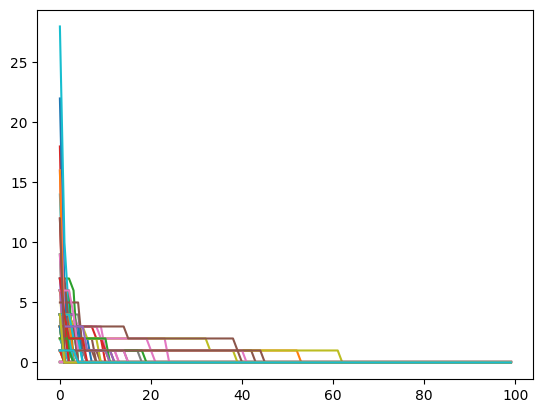

In [91]:
num_not_correct = 0
for i in range(100):
    x = ga(goal=84, population_size=100, num_generations=100, tournament_size=10, mutation_prob=0.3, elitism_size=5)
    if x.fitness != 0:
        num_not_correct += 1

In [92]:
num_not_correct

0